In [16]:
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchvision import transforms as tfs
from PIL import Image
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import time

In [17]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole) ##If True, then your GPU is enabled and you are able to make use of it

True


In [133]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(30, 3).reshape(3,30)
input.shape

torch.Size([3, 30])

## Load data


In [162]:
url = "https://raw.githubusercontent.com/shreyasingh1/epilepsypcm/shreya/experiments/newDF.csv"
dataset = pd.read_csv(url).drop(['Unnamed: 0','Channels'], axis = 1) 
dataset = dataset.drop(labels =1)
df_train, df_test = train_test_split(dataset,test_size=0.22, random_state=100)
y_train = torch.Tensor(df_train['outcome'].to_numpy())
x_train = torch.Tensor(df_train.drop(['outcome'], axis = 1).to_numpy())
y_test = torch.Tensor(df_test['outcome'].to_numpy())
x_test = torch.Tensor(df_test.drop(['outcome'], axis = 1).to_numpy())
# dataloaders:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)
TRAIN_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
train_dataloader = torch.utils.data.DataLoader(train, batch_size=TRAIN_BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=TEST_BATCH_SIZE, shuffle=False)
x_train.shape

torch.Size([240, 14])

## Model

In [163]:
class CNNet(nn.Module):
    
    """
    
    """
    
    def __init__(self,input_size=2):
        """
        
        """
        ## Inherent Torch Module
        super(CNNet, self).__init__()

        ##TODO: Initialize Model Layers
        self.layer1 = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.ff = nn.Linear(256, 32)
        self.fc = nn.Linear(32, input_size)

    def forward(self, input_data):
        """
        
        """
        ##TODO: Setup Forward Pass
        out = self.layer1(input_data)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.ff(out)
        out = self.fc(out)
        return out


In [169]:
def eval_cnn(loader, verbose = 1):
    '''
    This function caculate for accuracy and loss. 
    Code reference: 601.482/682 Deep Learning L9
    '''
    correct = 0
    loss_sum = 0
    total = 0
    for images, labels in loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        x_new = torch.dstack((images,images))
        x_new = x_new.permute(2,0,1)
        y = labels.to(torch.int64)
        outputs = model(x_new)
        loss_sum += loss_f(outputs,y)
        total += y.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted.float() == labels.float()).sum()
    if verbose:
        if loader == train_dataloader:
            print('Train accuracy: %f %%' % (100.0 * correct / total))
            print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))
        elif loader == test_dataloader:
            print('Test accuracy: %f %%' % (100.0 * correct / total))
            print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))
    return 100.0 * correct.cpu().data.numpy().item() / total, loss_sum.cpu().data.numpy().item() / total
    
    

## Train

In [176]:
def train_cnn(model,
          optimizer,
          loss_metric,
          lr,
          epochs=50,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          **kwargs):
    """
    
    """
    ##TODO: Implement a training loop

    #defining train loss & train/test/validation accuracy recording arrays for later visualization/plotting:
    train_loss_store = []
    train_perc_store = []
    val_perc_store = []
    test_perc_store = []

    print("Starting Training")
    #training loop:
    m = 0
    for epoch in range(epochs):
        time1 = time.time() #timekeeping
        verbose = 0
        for i, (x,y) in enumerate(train_dataloader):
            if gpu_boole:
                x = x.cuda()
                y = y.cuda()
            #loss calculation and gradient update:
            if i > 0 or epoch > 0:
                optimizer.zero_grad()
            x_new = torch.dstack((x,x))
            x_new = x_new.permute(2,0,1)
            y = y.to(torch.int64)
            m = m+1
            # print(m)
            outputs = model.forward(x_new)
            loss = loss_metric(outputs,y)
            loss.backward()    
            #performing update:
            optimizer.step()
            
        if epoch % 10 == 9 : 
            verbose = 1
            print()
            print("Epoch",epoch+1,':')
    
        train_perc, train_loss = eval_cnn(train_dataloader,verbose=verbose)
        test_perc, test_loss = eval_cnn(test_dataloader,verbose=verbose)
        train_loss_store.append(train_loss)
        train_perc_store.append(train_perc)
        test_perc_store.append(test_perc)

        time2 = time.time() #timekeeping
        
        if epoch % 10 == 9 : 
            print('Elapsed time for epoch:',time2 - time1,'s')
            print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')

    ## Plotting epoch-wise train loss curve:
    plt.plot(train_loss_store, '-o', label = 'train_loss', color = 'orange')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Loss At Last epoch')
    plt.legend()
    plt.show()

    
    ## Plotting epoch-wise accuracy curve for dataset:
    fig, ax = plt.subplots()
    ax.plot(test_perc_store, '-o', label = 'test_perc', color = 'red')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Accuracy At Last epoch')
    plt.legend()
    plt.show()


Starting Training

Epoch 10 :
Train accuracy: 86.666672 %
Train loss: 0.177401
Test accuracy: 88.235298 %
Test loss: 0.188837
Elapsed time for epoch: 0.28438806533813477 s
ETA of completion: 4.692403078079224 minutes

Epoch 20 :
Train accuracy: 86.666672 %
Train loss: 0.172823
Test accuracy: 88.235298 %
Test loss: 0.185982
Elapsed time for epoch: 0.2815816402435303 s
ETA of completion: 4.599166790644328 minutes

Epoch 30 :
Train accuracy: 86.666672 %
Train loss: 0.155667
Test accuracy: 88.235298 %
Test loss: 0.194542
Elapsed time for epoch: 0.2754068374633789 s
ETA of completion: 4.452410538991292 minutes

Epoch 40 :
Train accuracy: 87.500008 %
Train loss: 0.147322
Test accuracy: 88.235298 %
Test loss: 0.210113
Elapsed time for epoch: 0.28650689125061035 s
ETA of completion: 4.584110260009766 minutes

Epoch 50 :
Train accuracy: 87.500008 %
Train loss: 0.142507
Test accuracy: 85.294121 %
Test loss: 0.218677
Elapsed time for epoch: 0.28114962577819824 s
ETA of completion: 4.4515357414881

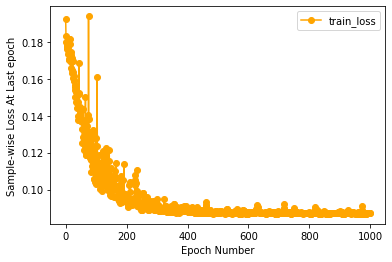

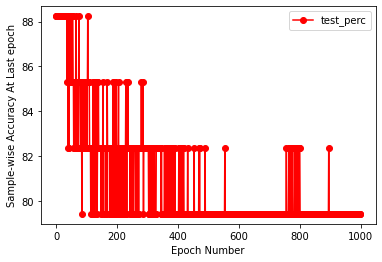

In [177]:
## Hyperparameters
EPOCH = 1000
LR = 0.01 ##TODO: Choose a Learning Rate

## Setting up the model, optimizer, and loss function
model = CNNet()
if gpu_boole:
  model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = LR) ##TODO: Choose an optimized
loss_f = nn.CrossEntropyLoss() ##TODO: Choose a loss

## Run Training Loop
train_cnn(model=model, optimizer=optimizer, loss_metric=loss_f, epochs=EPOCH, lr=LR)